#  Neural Turing Machines: Reports and Discussions

---

In this file we will report on the implemention of the Neural Turing Machine (NTM) as described in *[Neural Turing Machines](https://arxiv.org/abs/1410.5401)*. The goal is
to better understand attention and memory augmented networks, and the difficulties encountered
when training them. This report will be divided into $3$ main parts, as follows:


1.   **Filling in the Gaps:** Here we will attempt to cover some missing details of the paper.
2.   **Report:** Here we will report on the followings:
  *  **(a)** The total number of parameters for each model
  *  **(b)** Hyper-parameter values
  *  **(c)** Generalization of the models to longer sequences
  *  **(d)** Visualizing the read and write heads/attention
  *  **(e)** Understanding the shift operator
3.   **Discussion:** Here we will discuss the difficulties we have encountered during this task and the improvements that can be done for further work on this topic. We will also provide some analysis of the data we observed.







## 1. Filling in the Gaps
In this section we will attempt to provide details on the followings:


1.   **Parameter Constraints:** Describing how we have constrained the output of the controller at each time step to satisfy the constraints on their parameters.
2.   **Dependencies:** Describing the dependencies between: $x_t$, $M_{t-1}$, $M_t$, $r_{t-1}$, $r_t$, $e_t$, $a_t$, and $o_t$




### 1.1 Parameter Constraints
The output of the controller at each time step consists of parameters that have constraints. For example, $\beta \in (0,\infty)$ Using the following equations, we will describe how to constrain the output to satisfy them.
The parameters of the output of the controller are:


1.   **$g$:** The constraint on this parameter indicated by the paper is that it has to belong to$(0,1)$. 
      
      To satisfy this we will have $g=\sigma(\hat{g})$ the choice that we made here satisfies $g\in(0,1)$ hence the reason we chose the sigmoid function.
      
2.   **$\gamma$:** The paper indicates that this parameter has to be greater than or equal to $1$.

      To achieve this condition, we will have $\gamma$ to be given by $\gamma=\mathrm{log}(\exp(\hat{\gamma})+1)+1$, for really small value of $\hat{\gamma}$ this will almost be $1$ and for any other value of $\hat{\gamma}$, it will always be greater than $1$.

3.   **$s$:** The paper indicates that $s$ has to be the normalized distribution over all allowed integer shifts, it then suggest one possible technique would be to use a $\mathrm{softmax}$ function for $s$, hence that is also what we will consider for this parameter.

4.   **$\beta$:** The paper requires that this parameter to be positive i.e. greater than zero.

     To satisfy this condition we let $\beta$ to be defined as $\beta=\exp(\hat{\beta})$. This definition insures that $\beta>0$ as required.
     
5.   **$k$:** The paper does not require any constraints on this parameter, hence $k\in \mathbb{R}^M$ and we can simply let $k=\hat{k}$ for this purpose. Note that for the task of copying binary values we could refine $k$ to a more specific and bounded version. However we decided to keep our approach and our implementation general.



### 1.2 Dependencies
In this section, we will show how we think the followings are dependent on each other.
* The input $x_t$
* The memory $M_{t-1}$ and $M_t$
* The output of the read head $r_{t-1}$ and $r_t$
* The erase and add vectors $e_t$ and $a_t$
* The output of the controller $o_t$

We will do this via the below diagram. Here $x$ represents **input** and $h_t$ is the **head vector** containing $(k_t,\beta_t,g_t,s_t,\gamma_t)$. In this diagram if $B$ is dependent on $A$ then there is an arrow from $A$ to $B$. Note that in the paper *[Neural Turing Machines](https://arxiv.org/abs/1410.5401)* the dependencies are described as follows:
    $$w_t,M_t\to r_t \ (1)$$
    $$M_{t-1},w_t,a_t,e_t\to M_t \ (2)$$
    $$h_t,M_t,w_{t-1}\to w_t \ (3)$$
But the indices used by the paper are problematic. For instance, relation $(3)$ needs $M_t$ to produce $w_t$ but according to relation $(2)$, $M_t$ needs $w_t$ to be produced. In order to fix these inconsistencies we used the following relations in the diagram:
    $$w_{t-1},M_{t-1}\to r_t \ (1)$$
    $$M_{t-1},w_{t-1},a_t,e_t\to M_t \ (2)$$
    $$h_t,M_t,w_{t-1}\to w_t \ (3)$$



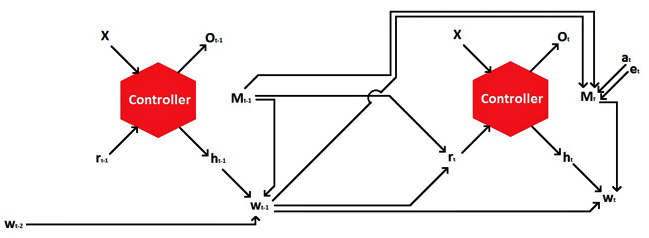

In [0]:
Image('depGraph_exp.jpg')


## 2. Report
As mentioned before, in this section we will report on our findings for the followings:

### **(a)** The Total Number of Parameters for Each Model
This is a report on the total number of parameters of all the models, including the baseline.<br>
We gathered the information presented in this section from the summary command executed in the file titled **Neural Turing Machines: Implementation** sections:


*   Running NTM with LSTM
*   Running NTM with Feedforward
*   Running LSTM

The result is as follows:
<table style="width:100%" border="1px solid black">
  <tr>
    <th>Method's Name</th>
    <th>Total Number of Parameters</th> 
  </tr>
  <tr>
    <td><center>LSTM-NTM</center></td>
    <td><center>62,201</center></td>
  </tr>
  <tr>
    <td><center>Feedforward-NTM</center></td>
    <td><center>13,201</center></td>
  </tr>
  <tr>
    <td><center>LSTM</center></td>
    <td><center>47,960</center></td>
  </tr>
</table>




### **(b)** Hyper-parameter Values
We experimented with a large set of candidates to choose our hyper-parameters from. We found out a few suitable candidates for our tasks which worked well across all our methods. Below we are providing the hyper-parameters we eventually used.
<center><table style="width:100%" border="1px solid black">
  <tr>
    <th>Method's Name</th>
    <th>Learning Rate</th>
    <th>Learning Rate Decay</th>
    <th>Batch Size</th>
    <th>Optimizer</th>
    <th>Activation Function</th>
    <th>Gradien Clipped at Max Norm of</th>
  </tr>
  <tr>
    <td><center>LSTM-NTM</center></td>
    <td><center>0.01</center></td>
    <td><center>0.5</center></td>
    <td><center>100</center></td>
    <td><center>Stochastic Gradient Descent</center></td>
    <td><center>Softmax</center></td>
    <td><center>10</center></td>
  </tr>
  <tr>
    <td><center>Feedforward-NTM</center></td>
    <td><center>0.01</center></td>
    <td><center>0.5</center></td>
    <td><center>100</center></td>
    <td><center>Stochastic Gradient Descent</center></td>
    <td><center>Softmax</center></td>
    <td><center>10</center></td>
  </tr>
  <tr>
    <td><center>LSTM</center></td>
    <td><center>0.001</center></td>
    <td><center>0.5</center></td>
    <td><center>100</center></td>
    <td><center>Adam</center></td>
    <td><center>Softmax</center></td>
    <td><center>10</center></td>
  </tr>
</table></center><br>
* Note: In order to eliminate other hyper-parameter values and to pick the best ones for our tasks, we only let each model to progress for $200$ epochs, we observed that the loss curve decreases towards $0$. We then picked the values for which the loss curve better approached zero. The main reason we did not let our models to be trained passed $200$ epochs was purely due to our limited computational resources. We will discuss these issues further in the **Discussion** section.

### **(c)** Generalization of The Models to Longer Sequences
One of the benefits of the NTM over a vanilla LSTM is the ability to learn a simple algorithm that generalize to larger sequences. We tested our models on sequences of $T\in\{10,20,30,\dots,100\}$, with $20$ different inputs for each $T$.<br>
For this experiment we expect to see a more robust generalization in the case of Neural Turing Machines, rather than the vanilla LSTM. This is because the vanilla LSTM has no access to any memory structure (in a Turing Machine sense of memory) and will fail to remember/recall the input for reproduction in the **Copy Task**. We expect that the inconsistency would increase with the length of the input, as the system will be having a harder time retaining the information. In the case of LSTM-NTM and Feedforward-NTM we expect to see better results for shorter sequences and slightly worse for the longer ones, note that this does not mean the methods are not robust but rather suggests that the cost will be slightly bigger for the longer sequences. We also expect to see a better performance in the case of LSTM-NTM since it will learn the **Copy Task** faster than Feedforward-NTM, and since we are limiting the training to $200$ epochs, LSTM-NTM has a better chance to perform better. Although theoretically the loss of both LSTM-NTM and Feedforard-NTM will converge and they both should perform somewhat similarly in this experiment. However, we did not have the needed computational powers, nor the time to achieve such states for either model and had to limit ourselves to $200$ epochs.

To get a sense of convergence of these models we can reference to the paper *[Neural Turing Machines](https://arxiv.org/abs/1410.5401)*, there we can see that the convergence for the LSTM-NTM and Feedforward-NTM happens around $10,000$ and $50,000$ epochs respectively. 

Below is the plot of average loss vs $T$ found within our experiments:

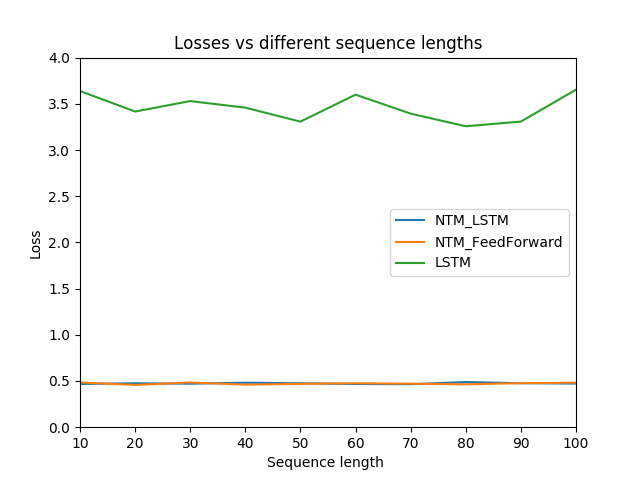

In [0]:
Image("avg_loss.png")

As we have expected there is a huge difference between the loss of the vanilla LSTM and the NTM methods. We can also observe that there is a wide variance in the cost resulted form the vanilla LSTM method, as opposed to almost stationary cost values of the NTM methods. As discussed above this difference is due to the lack of the memory of the vanilla LSTM in comparison to the NTM methods. Note that as we have predicted the NTM methods perform well robust under the variant of the input size, keeping the loss almost stationary. If we also look well we can notice that for most parts LSTM-NTM performs slightly better than the Feedforward-NTM due to the reasons mentioned before.

### **(d)** Visualizing The Read and Write Heads/Attention
We can visualize the read and write heads to get an idea of what algorithm is learned for the task. We first would like to take a look at the write and read head/attention provided by the paper *[Neural Turing Machines](https://arxiv.org/abs/1410.5401)*:

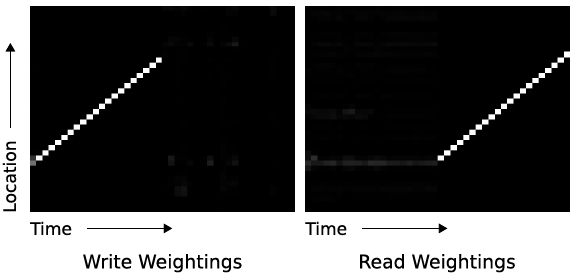

In [0]:
Image('paper_rw.jpg')

We can see here the behavior of the well trained algorithm. It first writes to the memory and then reads from it to complete the **Copy Task**, much like a real program would do by copying the seen entry data until the end of it and then placing it for show by reading from it. We are expecting to see the same type of behaviour from our algorithm as well. Below is the graph of the write and read head/attention provided by our algorithm (LSTM-NTM) for $T=10$:

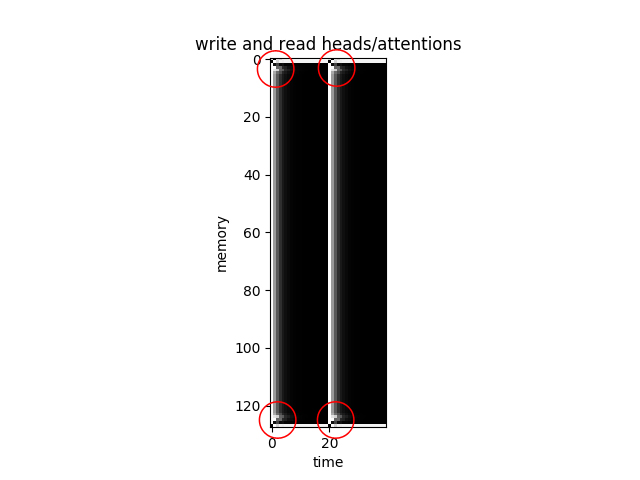

In [0]:
Image("exp_rw.jpg")

Note that our system is not well trained due to our limited resources (it has only been trained for $200$ epochs) but it is still performing as we have predicted. The accuracy of the **Copy Task** may not be optimal in our model however the mechanism is there, i.e. writing to memory upon seeing an input and then reading from the memory to predict the output or in other words completing the copying task. Our model as seen in the graph above, first tries to write to the memory and then reads form the exact same locations as it should however due to its low accuracy, it only does it well for the first few bits (the red circles). Although if we zoom in the region close to the red circles we will see that the white diagonal lines do actually continue further but turn more grayish. The interesting fact is that the grayish continuum we just mentioned does exist for both write and read, so the system is writing and reading but with less attention. We predict that with more training this attention would be adjusted and the diagonal white line would be more lengthy ($10$ in this case).

### **(e)** Understanding the shift operator
In this section we will discuss the relationship between the shift operator and convolutions. We will also modify the code-base so that the shift operator only allows forward shifts. we will show the snippet of code before and after the modification.

The shift operator defined in this setting is basically a convolution, if one knows what convolution is. In this discrete setting convolution is the sum of the point-wise multiplication of two vectors. Equation $[8]$ of the paper *[Neural Turing Machines](https://arxiv.org/abs/1410.5401)* depicts the said definition, hence the shift operator suggested in this setting is actually a simple convolution.

The main function in the code that applies shift operator is the following:

In [0]:
def gen_shift_tensor(leng, n_shifts):
    """
    Paramters:  
    ----------
    leng: int > 0, number of memory locations
    n_shifts: int > 0, number of allowed shifts (if 1, no shift)

    Returns:
    --------
    shift operation, a tensor with dimensions (n_shifts, leng, leng)
    """
    eye = np.eye(leng)
    shifts = range(n_shifts//2, -n_shifts//2, -1)
    C = np.asarray([np.roll(eye, s, axis=1) for s in shifts])
    return K.variable(C.astype(K.floatx()))

The above function first creates an identity matrix and then shifts it multiple times. The input **n_shifts** of this function indicates what kind of shifts we have. When the **shift_n** is $n$, we have a shift range of $\left\{-\frac{n}{2},\dots,-1,0,1,\dots,\frac{n}{2}\right\}$ i.e. for each value in this set there is a corresponding indentity matrix that has been shifted according to that value. Each of these shifted matrices when multiplied by another matrix, will shift that matrix with the corresponding shift number.

This function then returns a tensor with **n_shifts** of shifted versions of the identity matrix. Therefore, when this tensor is multiplied by a vector, the results are **n_shifts** shifted versions of that vector.

If we aim to allow only forward shifts, we need to not allow the negative numbers in this sequence. Therefore, we change this piece of code as follows:  

In [0]:
def gen_shift_tensor(leng, n_shifts):
    eye = np.eye(leng)
    shifts = range(n_shifts//2, 0 , -1)
    C = np.asarray([np.roll(eye, s, axis=1) for s in shifts])
    return K.variable(C.astype(K.floatx()))

The change is made on the third line: we pass $0$ as the second argument to the range function. This will only allow the positive numbers for the shift, which are only the forward shifts.

## 3. Discussion 
We have trained $3$ models for the **Copy Task** (LSTM, Forward-NTM, LSTM-NTM). In this section we aim to address the difficulties we have encountered during this process and provide some analysis of the observed values.

We tried to accomplish our experiment within a reasonable amount of time and with the limited computational resources at hand. Most of the results provided in this report is produced via the use of *[Google Colab](https://colab.research.google.com/)*. A few of the graphs (e.g the write and read head/attention) was produced off-line due to the incompatibility of Google Colab and Tensorflow (eg. *tensorflow.print*) at the time of this report. Using Google Colab let us to have access to a GPU unit which in return cut our computational time to almost $\frac{1}{12}$ of the time that would have been needed without a GPU. It also let us accomplish our task in parallel in a group environment. However, we encountered a few drawbacks. The system would sometimes disconnect us from the GPU and lead to loss of our progress due to memory limitations and/or the process using the GPU for too long. These issues forced us to choose to only train each of our models for a maximum of $200$ epochs. Hence, not being able to fully converge the loss to an optimal value as we originally desired. 

Note that according to the paper *[Neural Turing Machines](https://arxiv.org/abs/1410.5401)* to get a sense of convergence for the LSTM-NTM and Feedforward-NTM we had to train our models around $10,000$ and $50,000$ epochs respectively (the paper reported the loss over $1\mathrm{M}$ **epochs**). With our resources this would have taken us $27$ **hours** and $6$ **days** respectively. However as we have mentioned due to interruptions of Google Colab we could not let such trainings to take place.

Now we would like to bring our attention to the plot below:



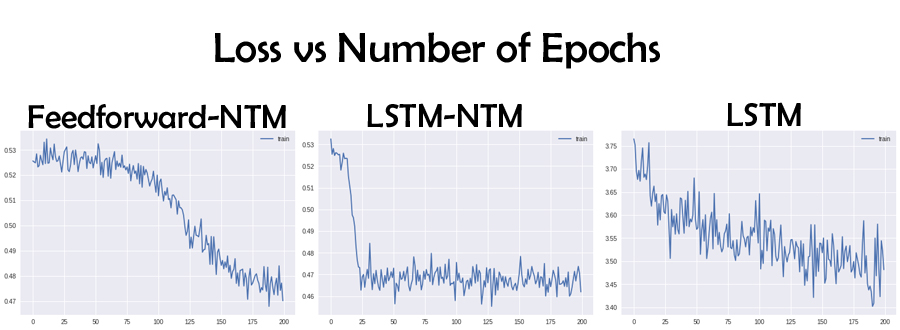

In [0]:
Image("loss_comp_all.jpg")

Here we can see that each of these models are progressing to decrease the loss. However, the vanilla LSTM is working in much larger scale of loss. If we let the vanilla LSTM to run even further we usually encounter a **reset** in the loss value, i.e. the loss increases and then starts to decreases again (i.e the model forgrets what it has learned and it starts to learn again). In the case of LSTM-NTM and Feedforward-NTM we can see that the loss is decreasing and the model is learning however the learning is more significant in the LSTM-NTM. To better compare their progress lets focus on the graph below:

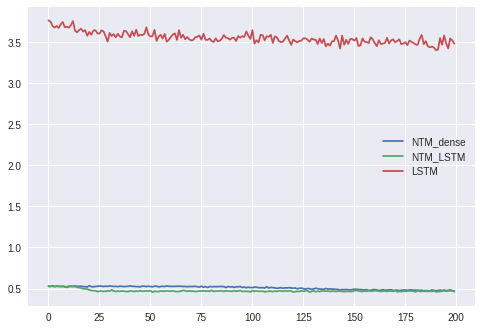

In [0]:
Image("loss_com_in_one.png")

Here we can see the significance of NTM methods over the vanilla LSTM. The loss scale is much higher for the vanilla LSTM and it somewhat does not decrease past the first few epochs, as we expected, since it is not suitable for the **Copy Task**. To better see the difference between the Feedforward-NTM and the LSTM-NTM lets focus now on the graph below:

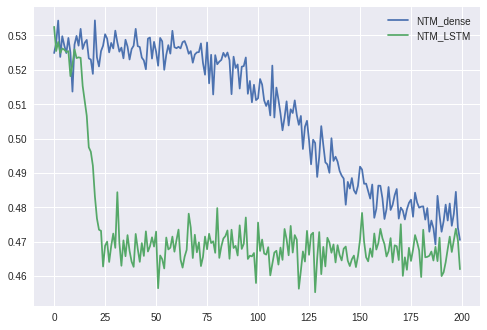

In [0]:
Image("loss_comop_in_one2.png")

Here we can see that the drop in loss for LSTM-NTM  is much more significant in comparison to Feedforward-LSTM. This is consistent with the theory mentioned in the paper *[Neural Turing Machines](https://arxiv.org/abs/1410.5401)*. As the training continues we expect that the LSTM-NTM converges faster in comparison to the Feedforward-NTM. One could investigate this claim by letting the models run for about $10,000$ and $50,000$ epochs respectively. A survey on the web revealed in practice, by using good hyper-parameters, the said epochs should be more or less enough for convergence. A few of such surveys could be found in the **References** section of our report.

## References

1.    Graves, Alex, Greg Wayne, and Ivo Danihelka. "Neural turing machines." arXiv preprint arXiv:1410.5401 (2014). https://arxiv.org/abs/1410.5401
2.    Graves, Alex. "Generating sequences with recurrent neural networks." arXiv preprint arXiv:1308.0850 (2013).[https://arxiv.org/abs/1308.0850](https://arxiv.org/abs/1308.0850)

3.   https://github.com/EderSantana/seya/blob/master/seya/layers/ntm.py

4.    https://github.com/flomlo/ntm_keras

5.    https://github.com/SigmaQuan/NTM-Keras

6.    https://github.com/carpedm20/NTM-tensorflow

7.    https://github.com/shawntan/neural-turing-machines

8.    https://github.com/snipsco/ntm-lasagne



